In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import importlib
import wrds
import os
import hdbscan

from scipy.spatial.distance import squareform, pdist
from functools import reduce
import seaborn as sns; sns.set_theme(color_codes=True);
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, AffinityPropagation, SpectralClustering, OPTICS
from sklearn.mixture import GaussianMixture

import wrds_loader

In [5]:
sp_500 = wrds_loader.download_snp_constituents()

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,permno,start,ending,date,ret,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker,gvkey,iid,linktype,linkprim,linkdt,linkenddt
0,52919.0,1982-04-08,2008-12-31,2000-01-31,0.041260,MERRILL LYNCH & CO INC,59018810,1973-05-16,2002-01-01,11.0,1.0,6211.0,MER,007267,01,LC,P,1971-07-27,2008-12-31 00:00:00.000000
2,34746.0,1996-03-08,2022-12-30,2000-01-31,-0.095400,FIFTH THIRD BANCORP,31677310,1982-11-01,2004-06-09,11.0,3.0,6711.0,FITB,004640,01,LU,P,1980-01-31,2023-11-27 10:41:49.076238
3,51377.0,1976-12-09,2011-09-23,2000-01-31,0.226277,NATIONAL SEMICONDUCTOR CORP,63764010,1973-01-17,2001-08-23,11.0,1.0,3674.0,NSM,007772,01,LC,P,1970-10-20,2011-09-30 00:00:00.000000
4,69607.0,1996-08-16,2000-11-21,2000-01-31,-0.146309,SEAGATE TECHNOLOGY INC,81180410,1994-12-12,2000-11-21,11.0,1.0,3572.0,SEG,009545,01,LU,P,1981-09-24,2000-11-30 00:00:00.000000
6,23990.0,1982-09-16,2009-04-01,2000-01-31,0.038402,ROHM & HAAS CO,77537110,1968-01-02,2002-01-01,11.0,1.0,2821.0,ROH,009217,01,LC,P,1962-01-31,2009-04-01 00:00:00.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175131,11891.0,2017-07-26,2022-12-30,2022-12-30,-0.090274,M G M RESORTS INTERNATIONAL,55295310,2021-03-31,2022-12-30,11.0,1.0,7011.0,MGM,014418,01,LU,P,1988-05-02,2023-11-27 10:41:49.076238
175132,20057.0,2020-11-17,2022-12-30,2022-12-30,0.009066,VIATRIS INC,92556V10,2021-03-25,2022-12-30,11.0,3.0,9999.0,VTRS,007637,01,LC,P,2020-11-17,2023-11-27 10:41:49.076238
175133,42906.0,1997-08-06,2022-12-30,2022-12-30,-0.079134,HUNTINGTON BANCSHARES INC,44615010,2014-01-17,2022-12-30,11.0,3.0,6020.0,HBAN,005786,01,LU,P,1972-12-14,2023-11-27 10:41:49.076238
175134,75825.0,2000-11-02,2022-12-30,2022-12-30,-0.076869,EOG RESOURCES INC,26875P10,2020-12-21,2022-12-30,11.0,1.0,1382.0,EOG,016478,01,LU,P,1989-10-04,2023-11-27 10:41:49.076238


In [22]:
importlib.reload(wrds_loader)
tickers = sp_500['ticker'].unique()
conn = wrds.Connection()
for ticker in tickers:
    data = wrds_loader.download_stock_data_crsp([ticker], conn=conn)
    data.to_feather(f'returns/{ticker}.feather')
conn.close()

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
# # List all files in the directory
# directory_path = 'returns'
# files = os.listdir(directory_path)
# all_df = []
# # Iterate through each file in the directory
# for filename in files:
#     file_path = os.path.join(directory_path, filename)
#     all_df.append(pd.read_feather(file_path))
#     print(f'{filename} Done')
df = pd.concat(all_df, ignore_index=True)
df

,permno,date,ret,shrout,prc,bid,ask,numtrd,ticker
0,10495.0,1962-07-02,0.021739,10715.0,41.125000,NaN,NaN,NaN,A
1,10495.0,1962-07-03,0.006079,10715.0,41.375000,NaN,NaN,NaN,A
2,10495.0,1962-07-05,-0.003021,10715.0,41.250000,NaN,NaN,NaN,A
3,10495.0,1962-07-06,-0.018182,10715.0,40.500000,NaN,NaN,NaN,A
4,10495.0,1962-07-09,0.006173,10715.0,40.750000,NaN,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...
9618747,13788.0,2022-12-23,0.005033,466072.0,145.759995,145.729996,145.740005,NaN,ZTS
9618748,13788.0,2022-12-27,-0.003156,466072.0,145.300003,145.279999,145.320007,NaN,ZTS
9618749,13788.0,2022-12-28,-0.010117,466072.0,143.830002,143.759995,143.820007,NaN,ZTS
9618750,13788.0,2022-12-29,0.030035,466072.0,148.149994,148.130005,148.139999,NaN,ZTS


#### Momentum

In [8]:
eps = 10 ** (-5)
def rolling_prod(series, window):
    """
    Compute rolling product over a window for a given series.
    """
    # Compute rolling product for entire series first
    rolling_cumprod = series.cumprod()

    # Compute rolling product over a given window by dividing the rolling cumprod at
    # the end of the window by the rolling cumprod at the beginning of the window
    return rolling_cumprod / rolling_cumprod.shift(window)

def calc_momentum(feather_path, spy_momentum=None):
    df = pd.read_feather(feather_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[['ticker', 'date', 'ret', 'shrout', 'prc']].drop_duplicates(subset=['ticker', 'date'])
    
    df['momentum'] = rolling_prod((1+df['ret']), 11 * 20) - 1
    df['momentum'] = df['momentum'].shift(20)
    
    if spy_momentum is not None:
        df = pd.merge(df, spy_momentum, on='date', how='inner')
        df['risk_adj_momentum'] = (eps + df['momentum']) / (eps + df['spy_momentum'])
    return df

# Load and preprocess SPY data
spy = calc_momentum('returns/SPY.feather')
spy = spy[['date', 'momentum']]
spy.columns = ['date', 'spy_momentum']
spy = spy[spy['date'].dt.year >= 1993]

# Specify the directory path
directory_path = 'returns'

# List all files in the directory
files = os.listdir(directory_path)

# Iterate through each file in the directory
for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = calc_momentum(file_path, spy_momentum=spy)
    df = df[['ticker', 'date', 'momentum', 'risk_adj_momentum']]
    df.to_csv(f'factors/momentum/{filename[:-7] + "csv"}', index=False)
    print(f'{filename} Done')

A.feather Done
AA.feather Done
AAL.feather Done
AAP.feather Done
AAPL.feather Done
ABBV.feather Done
ABC.feather Done
ABI.feather Done
ABK.feather Done
ABMD.feather Done
ABS.feather Done
ABT.feather Done
ABX.feather Done
ACAS.feather Done
ACE.feather Done
ACGL.feather Done
ACK.feather Done
ACN.feather Done
ACS.feather Done
ACT.feather Done
ACV.feather Done
ADBE.feather Done
ADCT.feather Done
ADI.feather Done
ADM.feather Done
ADNT.feather Done
ADP.feather Done
ADPT.feather Done
ADS.feather Done
ADSK.feather Done
ADT.feather Done
AEE.feather Done
AEP.feather Done
AES.feather Done
AET.feather Done
AFL.feather Done
AFS.feather Done
AGC.feather Done
AGN.feather Done
AHC.feather Done
AHP.feather Done
AIG.feather Done
AIV.feather Done
AIZ.feather Done
AJG.feather Done
AKAM.feather Done
AKS.feather Done
AL.feather Done
ALB.feather Done
ALGN.feather Done
ALK.feather Done
ALL.feather Done
ALLE.feather Done
ALTR.feather Done
ALXN.feather Done
AM.feather Done
AMAT.feather Done
AMCC.feather Done
AM

HMA.feather Done
HNZ.feather Done
HOG.feather Done
HOLX.feather Done
HON.feather Done
HOT.feather Done
HP.feather Done
HPC.feather Done
HPE.feather Done
HPQ.feather Done
HRB.feather Done
HRC.feather Done
HRL.feather Done
HRS.feather Done
HSIC.feather Done
HSP.feather Done
HST.feather Done
HSY.feather Done
HUM.feather Done
HWM.feather Done
HWP.feather Done
IACI.feather Done
IBM.feather Done
ICE.feather Done
IDXX.feather Done
IEX.feather Done
IFF.feather Done
IGT.feather Done
IIN.feather Done
IKN.feather Done
ILMN.feather Done
IMNX.feather Done
INCY.feather Done
INFO.feather Done
INTC.feather Done
INTU.feather Done
INVH.feather Done
IP.feather Done
IPG.feather Done
IPGP.feather Done
IQV.feather Done
IR.feather Done
IRM.feather Done
ISRG.feather Done
IT.feather Done
ITT.feather Done
ITW.feather Done
IVZ.feather Done
J.feather Done
JAVA.feather Done
JBHT.feather Done
JBL.feather Done
JCI.feather Done
JCP.feather Done
JDSU.feather Done
JEC.feather Done
JEF.feather Done
JHF.feather Done
JKHY

TMK.feather Done
TMO.feather Done
TMPW.feather Done
TMUS.feather Done
TNB.feather Done
TOS.feather Done
TOY.feather Done
TPR.feather Done
TRB.feather Done
TRGP.feather Done
TRIP.feather Done
TRMB.feather Done
TROW.feather Done
TRV.feather Done
TRW.feather Done
TSCO.feather Done
TSG.feather Done
TSLA.feather Done
TSN.feather Done
TSO.feather Done
TSS.feather Done
TT.feather Done
TTWO.feather Done
TUP.feather Done
TWC.feather Done
TWTR.feather Done
TWX.feather Done
TX.feather Done
TXN.feather Done
TXT.feather Done
TXU.feather Done
TYC.feather Done
TYL.feather Done
U.feather Done
UA.feather Done
UAA.feather Done
UAL.feather Done
UCL.feather Done
UCM.feather Done
UDR.feather Done
UHS.feather Done
UIS.feather Done
UK.feather Done
ULTA.feather Done
UMG.feather Done
UN.feather Done
UNH.feather Done
UNM.feather Done
UNP.feather Done
UPC.feather Done
UPR.feather Done
UPS.feather Done
URBN.feather Done
URI.feather Done
USB.feather Done
UST.feather Done
USW.feather Done
UTX.feather Done
UVN.feath

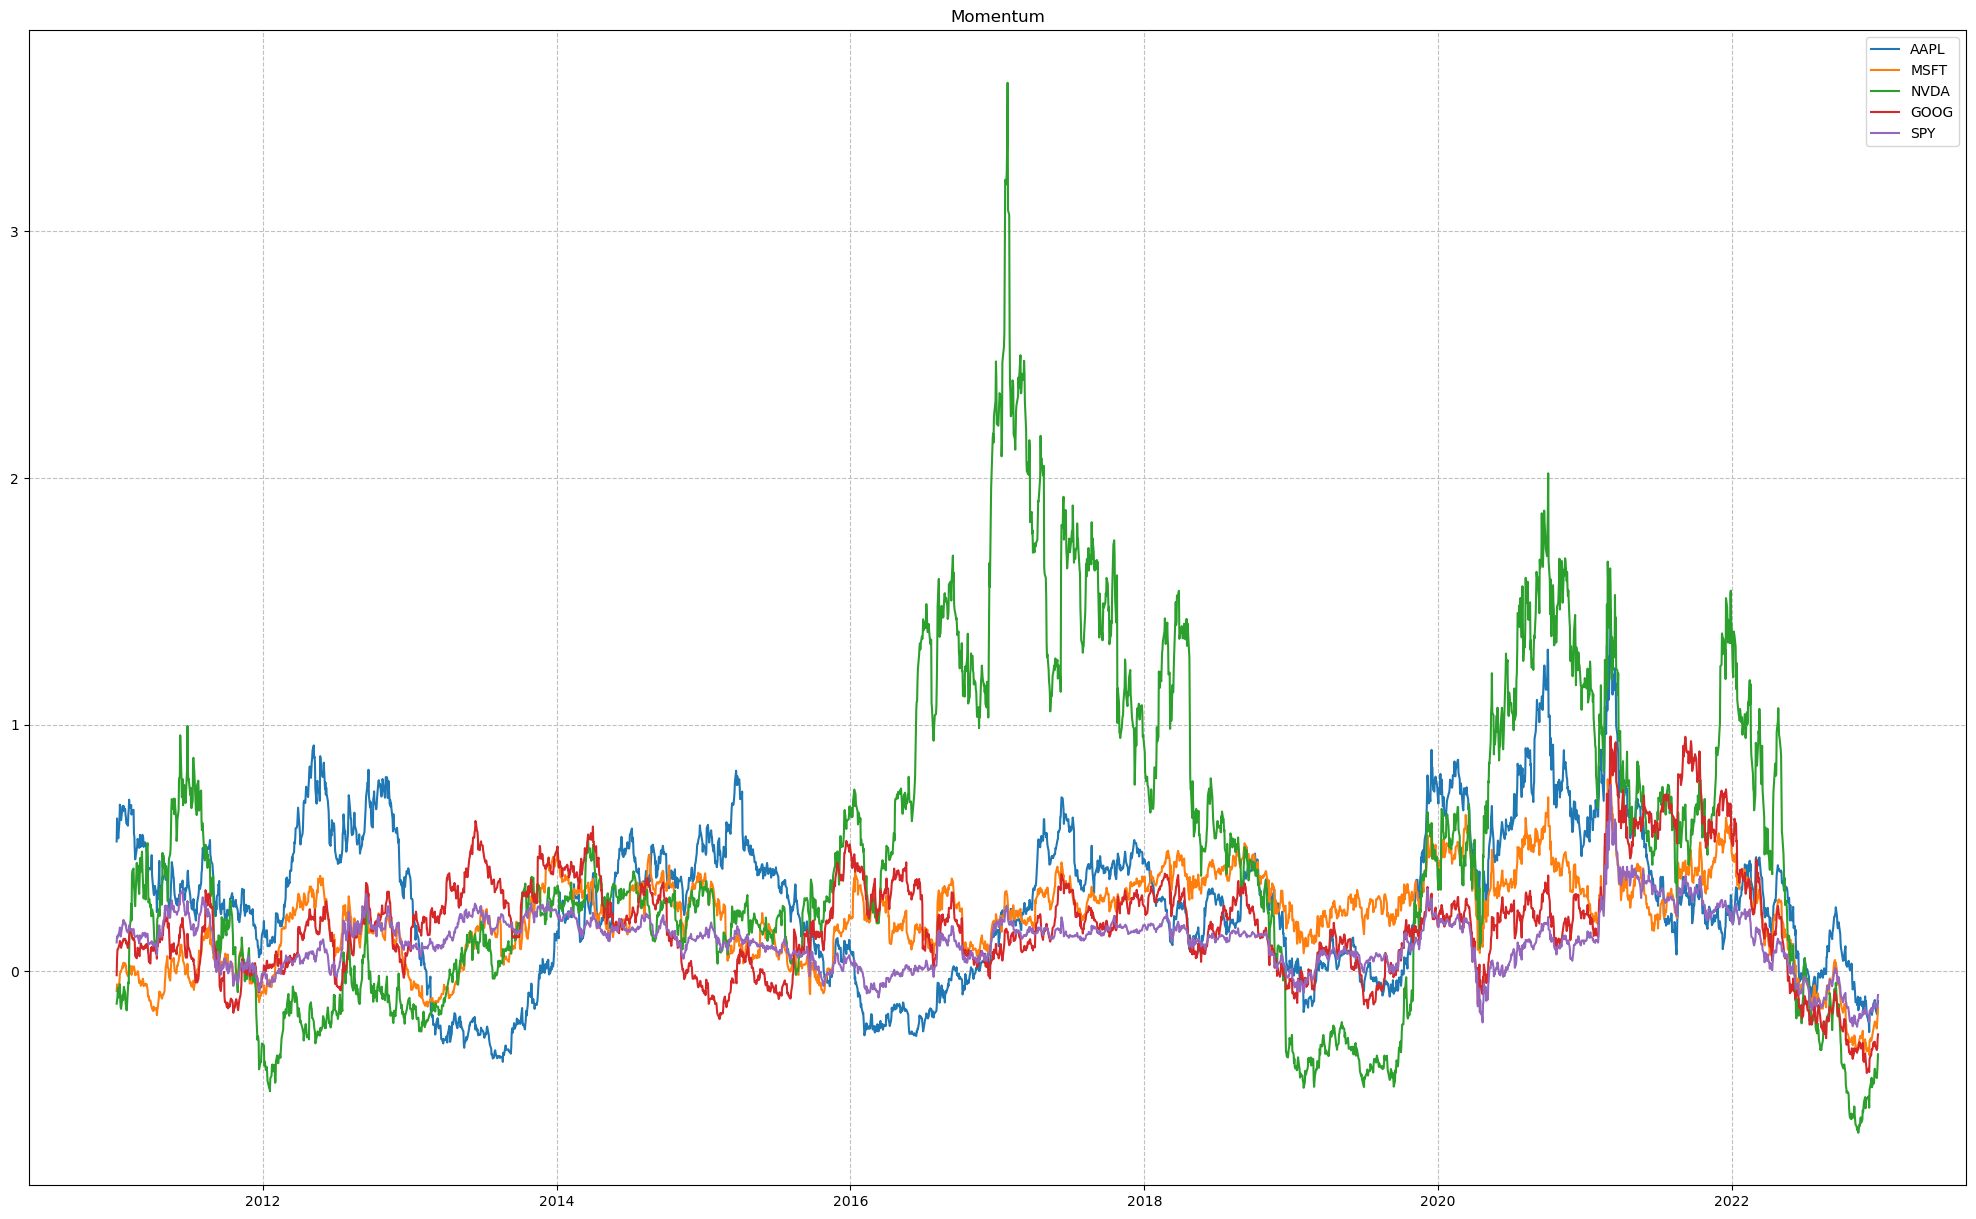

In [13]:
aapl = pd.read_feather('factors/momentum/AAPL.feather')
msft = pd.read_feather('factors/momentum/MSFT.feather')
nvda = pd.read_feather('factors/momentum/NVDA.feather')
goog = pd.read_feather('factors/momentum/GOOG.feather')
spy = pd.read_feather('factors/momentum/SPY.feather')

aapl = aapl[aapl['date'].dt.year > 2010]
msft = msft[msft['date'].dt.year > 2010]
nvda = nvda[nvda['date'].dt.year > 2010]
goog = goog[goog['date'].dt.year > 2010]
spy = spy[spy['date'].dt.year > 2010]

plt.figure(figsize=(25,15))
plt.title('Momentum')
plt.grid(linestyle='--', color='silver')

plt.plot(aapl['date'], aapl['momentum'], label='AAPL')
plt.plot(msft['date'], msft['momentum'], label='MSFT')
plt.plot(nvda['date'], nvda['momentum'], label='NVDA')
plt.plot(goog['date'], goog['momentum'], label='GOOG')
plt.plot(spy['date'], spy['momentum'], label='SPY')

plt.legend()
plt.show()

#### 1 month reversal

In [11]:
def calc_reversal(feather_path, spy_reversal=None):
    df = pd.read_feather(feather_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[['ticker', 'date', 'ret', 'shrout', 'prc']].drop_duplicates(subset=['ticker', 'date'])

    df['1M_reversal*'] = (1/rolling_prod((1+df['ret']), 20)).shift(1).fillna(eps)
    df['1M_reversal'] = (-rolling_prod((1+df['ret']), 20)).shift(1).fillna(eps)
    
    if spy_reversal is not None:
        df = pd.merge(df, spy_reversal, on='date', how='inner')
        df['risk_adj_1M_reversal'] = (eps + df['1M_reversal']) / (eps + df['spy_1M_reversal'])
        df['risk_adj_1M_reversal*'] = (eps + df['1M_reversal*']) / (eps + df['spy_1M_reversal*'])
    return df

# Load and preprocess SPY data
spy = calc_reversal('returns/SPY.feather')
spy = spy[['date', '1M_reversal', '1M_reversal*']]
spy.columns = ['date', 'spy_1M_reversal', 'spy_1M_reversal*']
spy = spy[spy['date'].dt.year >= 1993]

# Specify the directory path
directory_path = 'returns'

# List all files in the directory
files = os.listdir(directory_path)

# Iterate through each file in the directory
for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = calc_reversal(file_path, spy_reversal=spy)
    df = df[['ticker', 'date', '1M_reversal', '1M_reversal*', 'risk_adj_1M_reversal', 'risk_adj_1M_reversal*']]
    filename = filename.split(".")[0] + ".csv"
    df.to_csv(f'factors/1_month_reversal/{filename}')
    print(f'{filename} Done')

A.csv Done
AA.csv Done
AAL.csv Done
AAP.csv Done
AAPL.csv Done
ABBV.csv Done
ABC.csv Done
ABI.csv Done
ABK.csv Done
ABMD.csv Done
ABS.csv Done
ABT.csv Done
ABX.csv Done
ACAS.csv Done
ACE.csv Done
ACGL.csv Done
ACK.csv Done
ACN.csv Done
ACS.csv Done
ACT.csv Done
ACV.csv Done
ADBE.csv Done
ADCT.csv Done
ADI.csv Done
ADM.csv Done
ADNT.csv Done
ADP.csv Done
ADPT.csv Done
ADS.csv Done
ADSK.csv Done
ADT.csv Done
AEE.csv Done
AEP.csv Done
AES.csv Done
AET.csv Done
AFL.csv Done
AFS.csv Done
AGC.csv Done
AGN.csv Done
AHC.csv Done
AHP.csv Done
AIG.csv Done
AIV.csv Done
AIZ.csv Done
AJG.csv Done
AKAM.csv Done
AKS.csv Done
AL.csv Done
ALB.csv Done
ALGN.csv Done
ALK.csv Done
ALL.csv Done
ALLE.csv Done
ALTR.csv Done
ALXN.csv Done
AM.csv Done
AMAT.csv Done
AMCC.csv Done
AMCR.csv Done
AMD.csv Done
AME.csv Done
AMG.csv Done
AMGN.csv Done
AMP.csv Done
AMR.csv Done
AMT.csv Done
AMZN.csv Done
AN.csv Done
ANDV.csv Done
ANDW.csv Done
ANET.csv Done
ANF.csv Done
ANR.csv Done
ANSS.csv Done
ANTM.csv Done
AOC.cs

MEA.csv Done
MEDI.csv Done
MEE.csv Done
MEL.csv Done
MER.csv Done
MERQ.csv Done
MET.csv Done
META.csv Done
MFE.csv Done
MGM.csv Done
MHFI.csv Done
MHK.csv Done
MHP.csv Done
MHS.csv Done
MI.csv Done
MIL.csv Done
MIR.csv Done
MJN.csv Done
MKC.csv Done
MKG.csv Done
MKTX.csv Done
MLM.csv Done
MMC.csv Done
MMI.csv Done
MMM.csv Done
MNK.csv Done
MNST.csv Done
MO.csv Done
MOH.csv Done
MOLX.csv Done
MON.csv Done
MOS.csv Done
MOT.csv Done
MPC.csv Done
MPWR.csv Done
MRK.csv Done
MRNA.csv Done
MRO.csv Done
MS.csv Done
MSCI.csv Done
MSFT.csv Done
MSI.csv Done
MTB.csv Done
MTC.csv Done
MTCH.csv Done
MTD.csv Done
MTG.csv Done
MTW.csv Done
MU.csv Done
MUR.csv Done
MWD.csv Done
MWV.csv Done
MWW.csv Done
MXIM.csv Done
MYG.csv Done
MYL.csv Done
MZ.csv Done
N.csv Done
NAV.csv Done
NAVI.csv Done
NBL.csv Done
NBR.csv Done
NC.csv Done
NCC.csv Done
NCE.csv Done
NCLH.csv Done
NCR.csv Done
NDAQ.csv Done
NDSN.csv Done
NE.csv Done
NEE.csv Done
NEM.csv Done
NFB.csv Done
NFLX.csv Done
NFX.csv Done
NGH.csv Done
NI.

#### Financial Ratios

In [10]:
importlib.reload(wrds_loader)
directory_path = 'returns'
files = os.listdir(directory_path)
conn = wrds.Connection()
for filename in files:
    ticker = filename.split(".")[0]
    data = wrds_loader.download_finratios(ticker, db=conn)
    data.to_csv(f'factors/finratios/{ticker}.csv')
    print(f'{ticker} Done')
conn.close()

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
A Done
AA Done
AAL Done
AAP Done
AAPL Done
ABBV Done
ABC Done
ABI Done
ABK Done
ABMD Done
ABS Done
ABT Done
ABX Done
ACAS Done
ACE Done
ACGL Done
ACK Done
ACN Done
ACS Done
ACT Done
ACV Done
ADBE Done
ADCT Done
ADI Done
ADM Done
ADNT Done
ADP Done
ADPT Done
ADS Done
ADSK Done
ADT Done
AEE Done
AEP Done
AES Done
AET Done
AFL Done
AFS Done
AGC Done
AGN Done
AHC Done
AHP Done
AIG Done
AIV Done
AIZ Done
AJG Done
AKAM Done
AKS Done
AL Done
ALB Done
ALGN Done
ALK Done
ALL Done
ALLE Done
ALTR Done
ALXN Done
AM Done
AMAT Done
AMCC Done
AMCR Done
AMD Done
AME Done
AMG Done
AMGN Done
AMP Done
AMR Done
AMT Done
AMZN Done
AN Done
ANDV Done
ANDW Done
ANET Done
ANF Done
ANR Done
ANSS Done
ANTM Done
AOC Done
AOL Done
AON Done
AOS Do

SCHW Done
SDS Done
SE Done
SEBL Done
SEDG Done
SEE Done
SEG Done
SFA Done
SGI Done
SGP Done
SHLD Done
SHW Done
SIAL Done
SIG Done
SII Done
SIVB Done
SJM Done
SLB Done
SLE Done
SLG Done
SLM Done
SLR Done
SMI Done
SMS Done
SNA Done
SNDK Done
SNI Done
SNPS Done
SNV Done
SO Done
SOTR Done
SOV Done
SPC Done
SPG Done
SPGI Done
SPLS Done
SPY Done
SRCL Done
SRE Done
SRV Done
SSP Done
STA Done
STE Done
STI Done
STJ Done
STLD Done
STR Done
STT Done
STX Done
STZ Done
SUB Done
SUN Done
SUNW Done
SV Done
SVU Done
SWK Done
SWKS Done
SWN Done
SWY Done
SYF Done
SYK Done
SYMC Done
SYY Done
T Done
TAN Done
TAP Done
TDC Done
TDG Done
TDY Done
TE Done
TECH Done
TEG Done
TEK Done
TEL Done
TER Done
TEX Done
TFC Done
TFX Done
TGNA Done
TGT Done
THC Done
TIE Done
TIF Done
TIN Done
TJX Done
TKR Done
TLAB Done
TMC Done
TMK Done
TMO Done
TMPW Done
TMUS Done
TNB Done
TOS Done
TOY Done
TPR Done
TRB Done
TRGP Done
TRIP Done
TRMB Done
TROW Done
TRV Done
TRW Done
TSCO Done
TSG Done
TSLA Done
TSN Done
TSO Done
TSS Don

In [8]:
directory_path = 'factors/1_month_reversal'
files = os.listdir(directory_path)
data = []
for filename in files:
    file_path = os.path.join(directory_path, filename)
    data.append(pd.read_csv(file_path))
pd.concat(data, axis=0, ignore_index=True).to_csv('1m_reversal_all.csv')

In [7]:
directory_path = 'factors/finratios'
files = os.listdir(directory_path)
data = []
for filename in files:
    file_path = os.path.join(directory_path, filename)
    data.append(pd.read_csv(file_path))
pd.concat(data, axis=0, ignore_index=True).to_csv('finratios_all.csv')

# CLUSTERING

In [3]:
directory_path = 'returns'
files = os.listdir(directory_path)

dfs = []  # A list to store DataFrames

for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = pd.read_feather(file_path)
    df = df[['ticker', 'date', 'ret']]
    ticker = filename.split('.feather')[0]
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].dt.year == 2021]
    df.rename(columns={'ret': ticker}, inplace=True)
    df.drop(columns=['ticker'], inplace=True)
    dfs.append(df.reset_index(drop=True))

In [4]:
dfs = [df.drop_duplicates(subset=['date']) for df in dfs]
merged_df = reduce(lambda x, y: pd.merge(x, y, on='date', how='left'), dfs)
merged_df

,date,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABK,...,XTO,XYL,YHOO,YNR,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
0,2021-01-04,0.002903,0.008677,-0.040583,-0.001079,-0.024719,-0.016239,-0.012889,NaN,NaN,...,NaN,-0.020631,NaN,NaN,-0.025239,-0.006035,-0.016132,-0.011740,NaN,-0.011541
1,2021-01-05,0.008176,0.018065,0.019828,-0.001080,0.012364,0.010341,0.013057,NaN,NaN,...,NaN,-0.001204,NaN,NaN,0.000095,0.017302,0.006453,0.015840,NaN,0.006969
2,2021-01-06,0.027422,0.065061,0.005833,0.057772,-0.033662,-0.008638,0.086027,NaN,NaN,...,NaN,0.042181,NaN,NaN,0.005481,0.028496,0.037444,0.112359,NaN,0.014691
3,2021-01-07,0.026609,0.000793,-0.009021,0.008541,0.034123,0.010703,0.037299,NaN,NaN,...,NaN,0.045389,NaN,NaN,-0.007612,-0.005928,0.036168,0.030509,NaN,-0.000897
4,2021-01-08,0.007134,-0.009512,-0.016255,0.014254,0.008631,0.005248,-0.000908,NaN,NaN,...,NaN,-0.010140,NaN,NaN,0.014678,-0.002197,-0.008873,-0.025405,NaN,0.006647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2021-12-27,0.005957,0.007918,-0.004929,0.018826,0.022975,0.009918,0.018297,NaN,NaN,...,NaN,0.006723,NaN,NaN,0.019728,0.008347,0.041071,0.010423,NaN,0.016494
248,2021-12-28,0.002772,-0.010697,0.020363,0.006892,-0.005767,-0.000149,0.003488,NaN,NaN,...,NaN,0.010398,NaN,NaN,-0.000217,0.003130,-0.014860,0.001587,NaN,-0.009168
249,2021-12-29,0.009235,0.007434,-0.026429,0.012178,0.000502,0.007218,0.007404,NaN,NaN,...,NaN,-0.001339,NaN,NaN,0.004928,0.000156,0.006362,0.005387,NaN,0.011382
250,2021-12-30,0.001432,-0.007043,0.001108,-0.014562,-0.006578,0.004211,0.003225,NaN,NaN,...,NaN,-0.002178,NaN,NaN,-0.001947,0.000312,-0.005956,-0.005043,NaN,-0.007570


In [70]:
returns_df = merged_df.set_index('date')
returns_df = returns_df.drop(columns='SPY')
nan_percentage = (returns_df.isnull().sum() / len(returns_df)) * 100
threshold = 100
columns_to_drop = nan_percentage[nan_percentage >= threshold].index
returns_df = returns_df.drop(columns=columns_to_drop)
returns_df = returns_df.T
returns_df = returns_df.fillna(0)
returns_df

date,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
A,0.002903,0.008176,0.027422,0.026609,0.007134,0.008579,-0.009208,0.000079,-0.007482,0.001428,...,0.004111,-0.006604,0.023534,0.018316,0.006506,0.005957,0.002772,0.009235,0.001432,-0.007646
AA,0.008677,0.018065,0.065061,0.000793,-0.009512,-0.017207,0.021173,-0.025518,0.026596,-0.072140,...,0.021677,-0.011539,0.069290,0.044374,0.000843,0.007918,-0.010697,0.007434,-0.007043,0.006249
AAL,-0.040583,0.019828,0.005833,-0.009021,-0.016255,-0.008592,0.025333,0.009753,0.058596,-0.041363,...,0.026029,0.020649,0.047399,0.007726,0.000000,-0.004929,0.020363,-0.026429,0.001108,-0.006087
AAP,-0.001079,-0.001080,0.057772,0.008541,0.014254,0.005645,0.033037,-0.027792,-0.017059,-0.021205,...,-0.026509,-0.019028,0.005167,0.014026,-0.002835,0.018826,0.006892,0.012178,-0.014562,0.009936
AAPL,-0.024719,0.012364,-0.033662,0.034123,0.008631,-0.023249,-0.001396,0.016227,-0.015127,-0.013731,...,-0.006502,-0.008122,0.019087,0.015319,0.003644,0.022975,-0.005767,0.000502,-0.006578,-0.003535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,-0.025239,0.000095,0.005481,-0.007612,0.014678,0.004853,0.000000,-0.004830,0.005880,-0.010763,...,-0.012426,-0.002729,0.013681,0.009447,0.005274,0.019728,-0.000217,0.004928,-0.001947,0.003396
ZBH,-0.006035,0.017302,0.028496,-0.005928,-0.002197,0.000315,0.005220,0.019521,-0.002025,-0.015373,...,0.003154,-0.016218,0.030028,0.018537,0.018119,0.008347,0.003130,0.000156,0.000312,-0.009589
ZBRA,-0.016132,0.006453,0.037444,0.036168,-0.008873,0.020519,-0.014113,0.011031,-0.001140,-0.006699,...,-0.005945,-0.030143,0.016521,0.000379,0.003411,0.041071,-0.014860,0.006362,-0.005956,-0.003916
ZION,-0.011740,0.015840,0.112359,0.030509,-0.025405,0.023604,0.009826,-0.011319,0.022595,-0.034862,...,-0.035765,-0.029412,0.037879,0.003406,0.008083,0.010423,0.001587,0.005387,-0.005043,0.000475


### HDBSCAN

D:\Applications\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\Applications\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

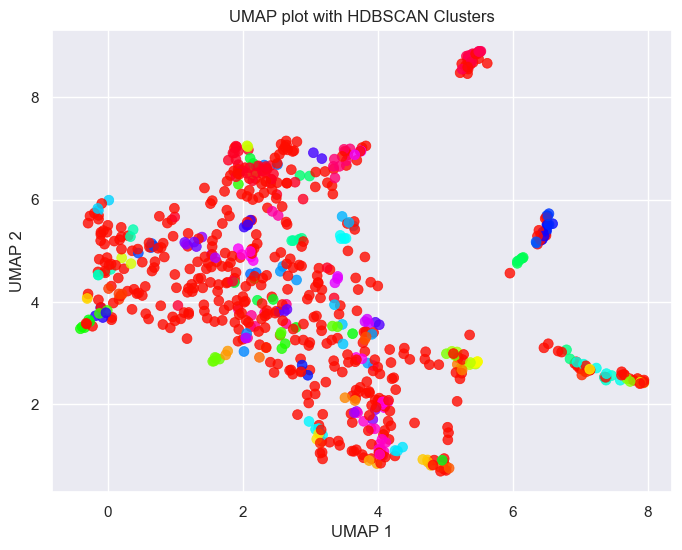

In [71]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(returns_df)

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric='manhattan')
cluster_labels = clusterer.fit_predict(df_scaled)
returns_df['HDBSCAN'] = cluster_labels 

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with HDBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### KMeans

D:\Applications\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


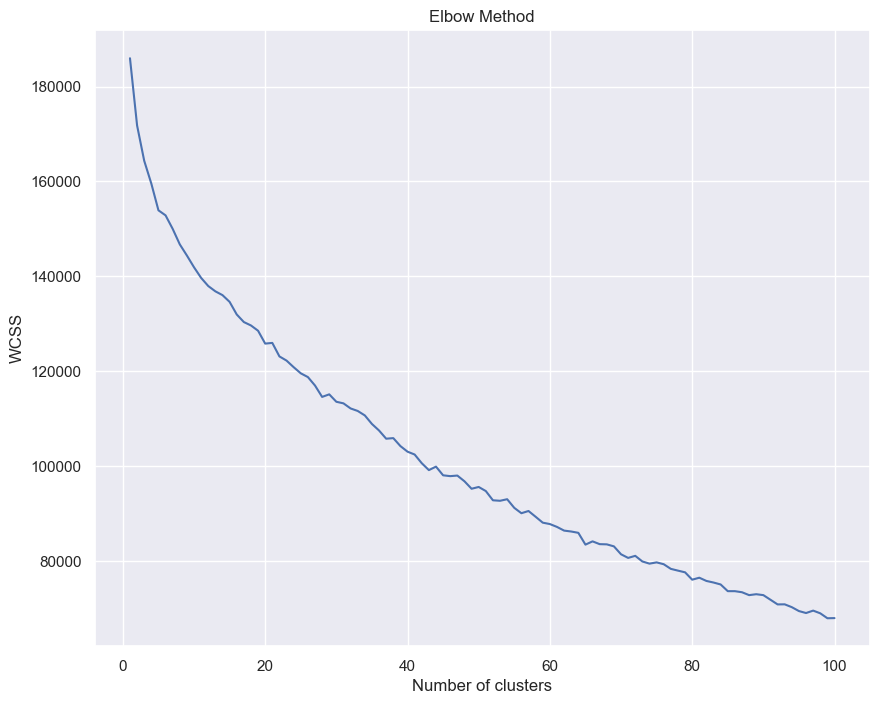

In [8]:
# Function to calculate WCSS for KMeans
def calculate_wcss(data):
    wcss = []
    for n in range(1, 101): # Let's test for 1 to 10 clusters
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Plot the WCSS to find the elbow
#wcss = calculate_wcss(df_scaled)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 101), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


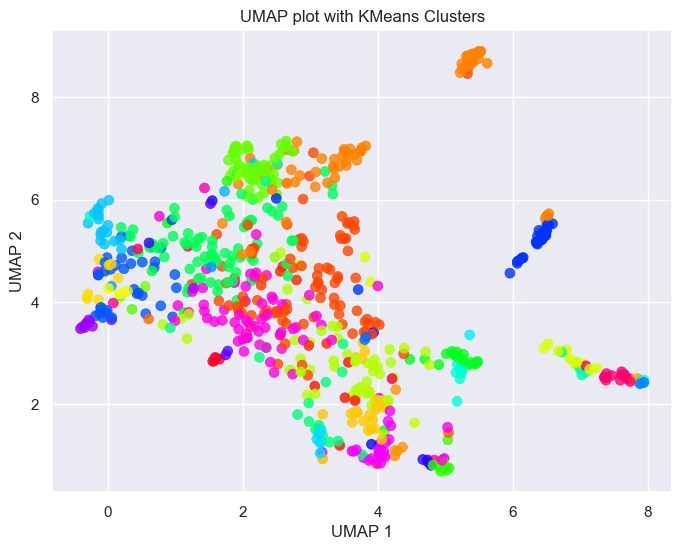

In [72]:
# Define the number of clusters for KMeans and GMM
n_clusters = 80

# K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)
returns_df['KMeans'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters without a legend
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))  # 'hsv' is cyclic, better for many clusters
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with KMeans Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### GMM

D:\Applications\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


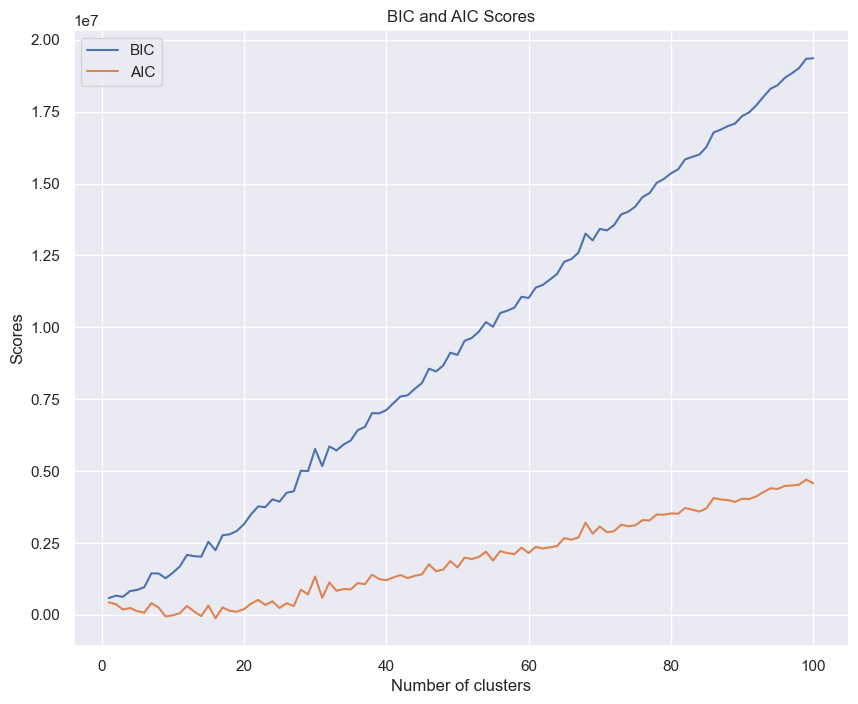

In [75]:
# Function to calculate BIC and AIC
def calculate_bic_aic(data):
    bics = []
    aics = []
    for n in range(1, 101): # Let's test for 1 to 10 clusters
        gmm = GaussianMixture(n_components=n)
        gmm.fit(data)
        bics.append(gmm.bic(data))
        aics.append(gmm.aic(data))
    return bics, aics

# Plot the BIC and AIC
#bics, aics = calculate_bic_aic(df_scaled)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 101), bics, label='BIC')
plt.plot(range(1, 101), aics, label='AIC')
plt.legend()
plt.title('BIC and AIC Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.show()

D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


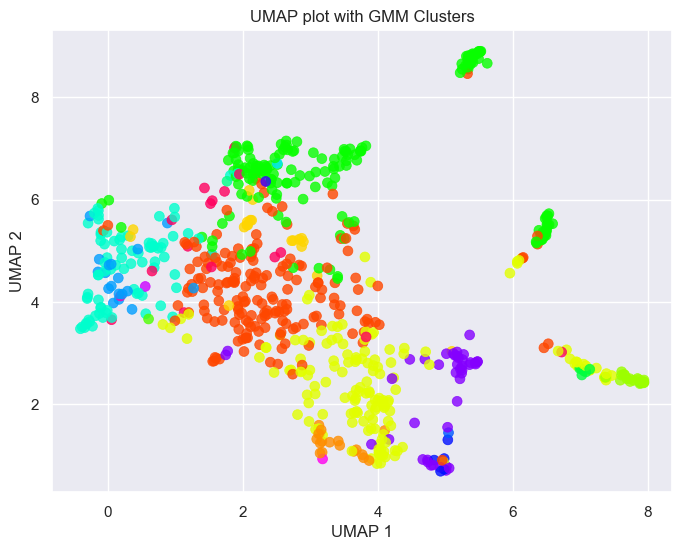

In [76]:
# Define the number of clusters for GMM
n_clusters = 20

# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
cluster_labels = gmm.fit_predict(df_scaled)
returns_df['GMM'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters without a legend
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))  # 'hsv' is cyclic, better for many clusters
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with GMM Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### DBSCAN

D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


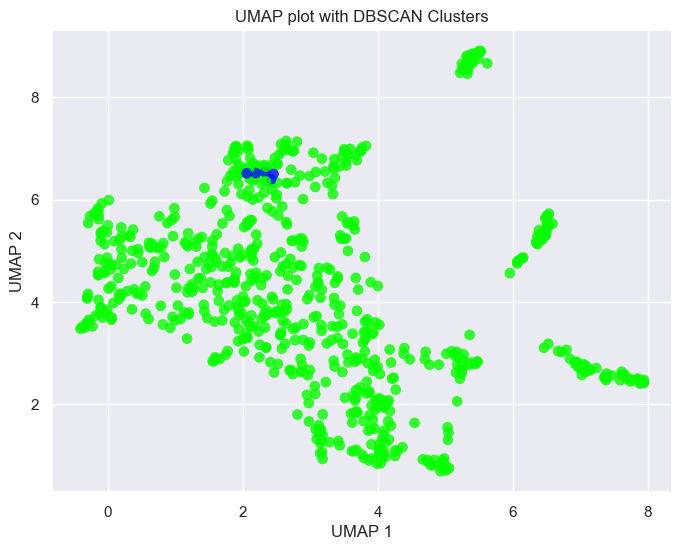

In [78]:
# DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=2)
cluster_labels = dbscan.fit_predict(df_scaled)
returns_df['DBSCAN'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))

sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with DBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### Other Clustering Models

D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


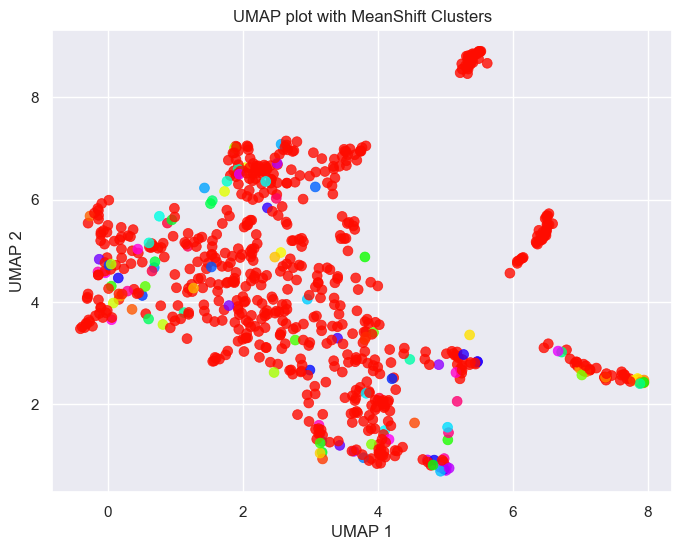

D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


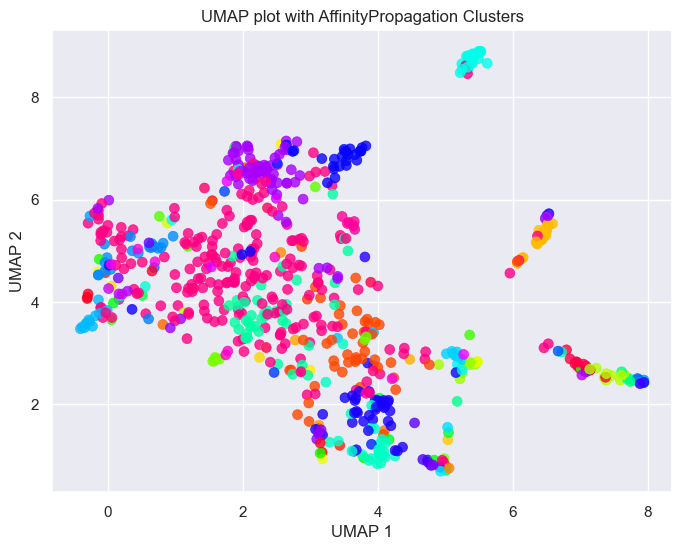

D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


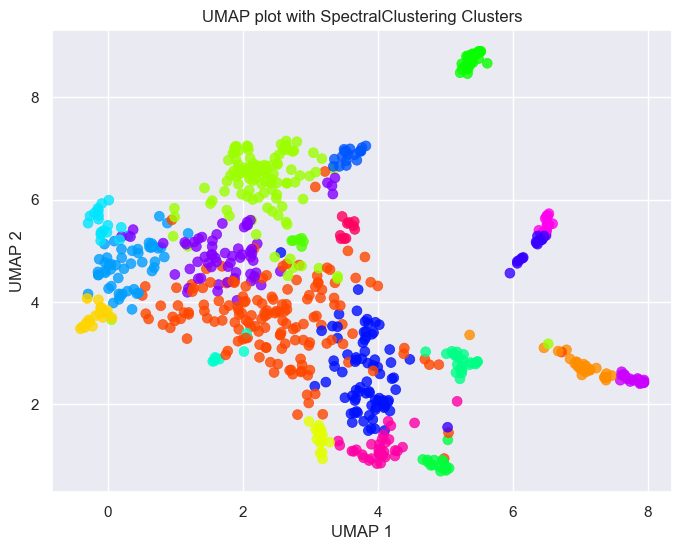

D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


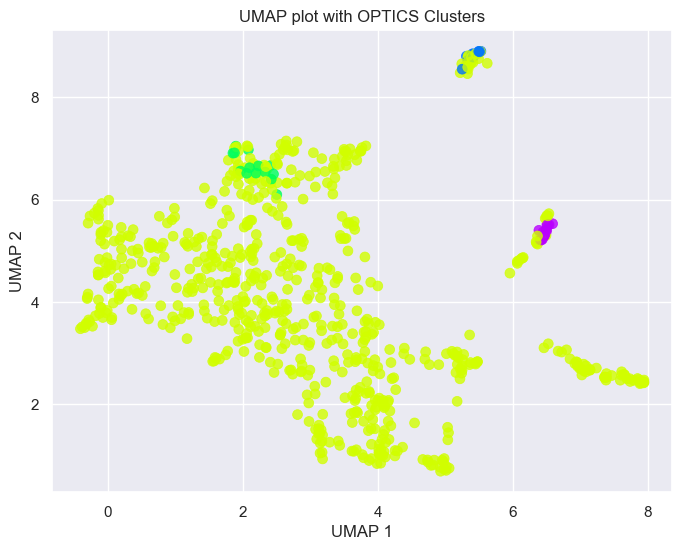

In [79]:
def apply_clustering(model, data):
    # Fit the model and predict the cluster labels
    cluster_labels = model.fit_predict(data)
    return cluster_labels

# List of clustering models to apply
clustering_models = [
    MeanShift(),  # May need bandwidth parameter adjusted
    AffinityPropagation(),  # Beware, complexity can be high
    SpectralClustering(n_clusters=n_clusters, random_state=42, affinity='nearest_neighbors'),
    OPTICS(min_samples=5, xi=0.05, min_cluster_size=10),  # Adjust parameters as needed
]

clustering_labels = {}

for model in clustering_models:
    model_name = model.__class__.__name__
    clustering_labels[model_name] = apply_clustering(model, df_scaled)
    returns_df[model_name] = clustering_labels[model_name]

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

for model_name, labels in clustering_labels.items():
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette('hsv', len(np.unique(labels)))  # Adjust the palette as needed
    sns.scatterplot(*embedding.T, hue=labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
    plt.title(f'UMAP plot with {model_name} Clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

In [85]:
clusters = returns_df[returns_df.columns[-8:]]
clusters = clusters.reset_index()
clusters.rename(columns={'index': 'Ticker'}, inplace=True)
clusters.to_csv('stock_clusters.csv', index=False)
clusters = pd.read_csv('stock_clusters.csv')
clusters

,Ticker,HDBSCAN,KMeans,GMM,DBSCAN,MeanShift,AffinityPropagation,SpectralClustering,OPTICS
0,A,-1,43,9,-1,0,117,10,-1
1,AA,-1,66,1,-1,35,0,3,-1
2,AAL,19,28,15,-1,0,30,8,-1
3,AAP,54,1,0,-1,0,56,0,-1
4,AAPL,59,31,9,-1,0,73,11,-1
...,...,...,...,...,...,...,...,...,...
732,YUM,86,31,0,-1,0,117,4,-1
733,ZBH,67,3,2,-1,0,117,15,-1
734,ZBRA,-1,49,9,-1,0,117,0,-1
735,ZION,84,67,3,-1,0,59,18,-1


# Portfolio Construction

In [114]:
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-12-31')
ticker_list = get_tickers(start_date, end_date, sp_500)
ticker_list = np.append(ticker_list, 'SPY')

In [130]:
def get_tickers(start_date, end_date, sp500):
    sp500['date'] = pd.to_datetime(sp500['date'])
    return sp500.loc[(sp500['date'] >= start_date) & (sp500['date'] <= end_date), 'ticker'].unique()
    
def get_weeks_df(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, closed=None)
    all_dates_df = pd.DataFrame({'date': date_range})
    all_dates_df.set_index('date', inplace=True)
    all_dates_df = all_dates_df.resample('W-MON').first()
    all_dates_df.reset_index(inplace=True)
    return all_dates_df
    
def weekly_returns(start_date, end_date, ticker_list):
    # Specify the directory path
    directory_path = 'returns'

    # List all files in the directory
    files = os.listdir(directory_path)
    all_dfs = []
    
    # Date Range
    all_dates_df = get_weeks_df(start_date, end_date)
    time_diff = (end_date - start_date).days
    
    # Iterate through each file in the directory
    for ticker in ticker_list:
        filename = ticker + '.feather'
        file_path = os.path.join(directory_path, filename)
        #print(file_path)
        df = pd.read_feather(file_path)
        df['date'] = pd.to_datetime(df['date'])
        df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]
        df = df.dropna(subset=['ret'])
        
        if len(df) >= (0.6 * time_diff):
            df['ret'] = 1 + df['ret']
            df.set_index('date', inplace=True)
            df = df.resample('W-MON').agg({'ticker': 'last', 'ret': 'prod'})
            df['ret'] = df['ret'] - 1
            df.reset_index(inplace=True)
            df = pd.merge(all_dates_df, df, how='left', on=['date']).drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)
            #print(df)
            ticker = df['ticker'].iloc[df['ticker'].first_valid_index()]
            df['ticker'] = df['ticker'].fillna(ticker)
            all_dfs.append(df)

            print(f"", end=' ')
            
    merged_df = all_dates_df
    for df in all_dfs:
        ticker = df['ticker'].iloc[0]
        df = df.rename(columns={'ret': ticker})
        df.drop(columns=['ticker', 'date'], inplace=True)
        merged_df = pd.concat([merged_df, df], axis=1)
    
    return merged_df.fillna(0)

def get_series(all_dates_df, factor_df, factor_name, ticker):
    factor_df['date'] = pd.to_datetime(factor_df['date'])
    merged_df = pd.merge(factor_df, all_dates_df, on='date', how='outer').drop_duplicates(subset=['date']).sort_values(by='date').fillna(method='ffill')
    merged_df = pd.merge(all_dates_df, merged_df, on='date', how='inner').sort_values(by='date').fillna(method='ffill')
    
    series = pd.to_numeric(merged_df[factor_name])
    series.name = ticker
    return series

def get_factors(start_date, end_date, ticker_list):
    factors_dict = {}
    all_dates_df = get_weeks_df(start_date, end_date)
    
    fact_list = ['momentum', 'risk_adj_momentum', 'pe_op_basic', 'bm', '1M_reversal', 'risk_adj_1M_reversal']
    for fact in fact_list:
        factors_dict[fact] = []
    
    momentum_path = 'factors/momentum'
    finratios_path = 'factors/finratios'
    reversal_path = 'factors/1_month_reversal'
    
    data = []
    counter = 0

    for ticker in ticker_list:
        filename = ticker + '.csv'
        
        momentum = pd.read_csv(os.path.join(momentum_path, filename))[['date', 'momentum', 'risk_adj_momentum']]
        finratio = pd.read_csv(os.path.join(finratios_path, filename))[['date', 'pe_op_basic', 'bm']]
        reversal = pd.read_csv(os.path.join(reversal_path, filename))[['date', '1M_reversal*', 'risk_adj_1M_reversal*']]
        
        factors_dict['momentum'].append(get_series(all_dates_df, momentum, 'momentum', ticker))
        factors_dict['risk_adj_momentum'].append(get_series(all_dates_df, momentum, 'risk_adj_momentum', ticker))
        factors_dict['pe_op_basic'].append(get_series(all_dates_df, finratio, 'pe_op_basic', ticker))
        factors_dict['bm'].append(get_series(all_dates_df, finratio, 'bm', ticker))
        factors_dict['1M_reversal'].append(get_series(all_dates_df, reversal, '1M_reversal*', ticker))
        factors_dict['risk_adj_1M_reversal'].append(get_series(all_dates_df, reversal, 'risk_adj_1M_reversal*', ticker))
        
        #print(f'{ticker}', end=' ')
    
    for fact in fact_list:
        factors_dict[fact] = pd.concat(factors_dict[fact], axis=1)
        factors_dict[fact]['date'] = all_dates_df['date']
    
    return factors_dict

def render_returns_data_for_clustering(start_date, end_date, ticker_list):
    directory_path = 'returns'
    files = os.listdir(directory_path)
    new_start_date = start_date - pd.DateOffset(days=365)
    new_end_date = end_date - pd.DateOffset(days=365)

    dfs = []  # A list to store DataFrames

    for ticker in ticker_list:
        filename = ticker + '.feather'
        file_path = os.path.join(directory_path, filename)
        df = pd.read_feather(file_path)
        df = df[['ticker', 'date', 'ret']]
        ticker = filename.split('.feather')[0]
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= new_start_date) & (df['date'] <= new_end_date)]
        df.rename(columns={'ret': ticker}, inplace=True)
        df.drop(columns=['ticker'], inplace=True)
        dfs.append(df.reset_index(drop=True))
        
    dfs = [df.drop_duplicates(subset=['date']) for df in dfs]
    merged_df = reduce(lambda x, y: pd.merge(x, y, on='date', how='left'), dfs)
    
    returns_df = merged_df.set_index('date')
    #returns_df = returns_df.drop(columns='SPY')
    nan_percentage = (returns_df.isnull().sum() / len(returns_df)) * 100
    threshold = 100
    columns_to_drop = nan_percentage[nan_percentage >= threshold].index
    returns_df = returns_df.drop(columns=columns_to_drop)
    returns_df = returns_df.T
    returns_df = returns_df.fillna(0)
    
    scaler = StandardScaler()
    return returns_df, scaler.fit_transform(returns_df)

def get_clusters(returns_df, df_scaled):
    dfs = [] 
    
    # List of clustering models to apply
    clustering_models = [
        AffinityPropagation(),  # Beware, complexity can be high
        SpectralClustering(n_clusters=80, random_state=42, affinity='nearest_neighbors'),
        KMeans(n_clusters=80, random_state=42),
        GaussianMixture(n_components=80, random_state=42)
    ]

    clustering_labels = pd.DataFrame(index=returns_df.index)

    for model in clustering_models:
        model_name = model.__class__.__name__
        clustering_labels[model_name] = apply_clustering(model, df_scaled)
        #returns_df[model_name] = clustering_labels[model_name]

    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(df_scaled)
    return clustering_labels

def apply_clustering(model, data):
    # Fit the model and predict the cluster labels
    cluster_labels = model.fit_predict(data)
    return cluster_labels

def normalize(weights):
    weights = weights.copy()
    total_sum = weights.abs().sum(axis=1)
    normalized_weights = weights.div(total_sum + 10e-12, axis=0)
    return normalized_weights

def enforce_boundary(weights, max_weights, min_weights):
    weights = normalize(weights)
    max_exceeded = weights.abs() > max_weights
    min_exceeded = weights.abs() < min_weights

    if max_exceeded.any().any():
        weights[max_exceeded] = max_weights * weights[max_exceeded].abs()/weights[max_exceeded]

    if min_exceeded.any().any():
        weights[min_exceeded] = min_weights * weights[min_exceeded].abs()/weights[min_exceeded]

    return normalize(weights)

def add_to_print(print_df, scheme, period_returns, weights_df):
    returns = period_returns * weights_df
    returns = (returns.sum(axis=1) * 100).round(4)
    returns.name = scheme
    print_df = pd.concat([print_df, returns], axis=1)
    return print_df

def run_framework(start_date, end_date, ticker_list):
    print_df = pd.DataFrame()
    print_df['Date'] = get_weeks_df(start_date, end_date)['date']
    print('Generating Factors')
    factor_dict = get_factors(start_date, end_date, ticker_list)
    returns = weekly_returns(start_date, end_date, ticker_list)    
    returns.drop(columns='date', inplace=True)
    print_df = pd.concat([print_df, (returns['SPY'] * 100).round(4)], axis=1)
    portfolio_returns = []
    
    print('Calculating Returns')
    for key in factor_dict:
        weights = factor_dict[key].drop(columns='date')
        max_wt, min_wt = 5/100, 0.01/100
        weights = enforce_boundary(weights, max_wt, min_wt)
        print_df = add_to_print(print_df, key, returns, weights)
        
    save_csv(print_df.T)
    print('Save to CSV Complete')
    return returns, factor_dict
    
def save_csv(data_frame, base_folder='ReturnSeries', file_name_prefix="FactorReturns"):
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")
    folder_path = os.path.join(base_folder, today_date)
    os.makedirs(folder_path, exist_ok=True)
    existing_files = [file for file in os.listdir(folder_path) if file.startswith(file_name_prefix)]
    new_file_name = f"{file_name_prefix}V{len(existing_files) + 1}.csv"
    file_path = os.path.join(folder_path, new_file_name)
    data_frame.to_csv(file_path)
    return file_path

In [131]:
returns, factor_dict = run_framework(start_date, end_date, ticker_list)

C:\Users\food4thought\AppData\Local\Temp\ipykernel_24188\3892264317.py:6: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  date_range = pd.date_range(start=start_date, end=end_date, closed=None)
C:\Users\food4thought\AppData\Local\Temp\ipykernel_24188\3892264317.py:6: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  date_range = pd.date_range(start=start_date, end=end_date, closed=None)


Generating Factors


C:\Users\food4thought\AppData\Local\Temp\ipykernel_24188\3892264317.py:6: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  date_range = pd.date_range(start=start_date, end=end_date, closed=None)


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Calculating Returns
Save to CSV Complete


In [155]:
def plot_barplot(data_points, labels):
    # Extract the first element and the last 5 elements
    first_element = data_points[0]
    last_elements = data_points[1:]

    # Corresponding labels for the last 5 elements
    last_labels = labels[1:]

    # Create a bar plot
    plt.figure(figsize=(18, 11))
    plt.bar(last_labels, last_elements, color='blue', alpha=0.7, label='Others')
    plt.axhline(y=first_element, color='red', linestyle='--', label='SPY')

    # Adding labels and title
    plt.xlabel('Labels')
    plt.ylabel('Values')
    plt.title('Bar Plot of Factor Portfolios vs. SPY')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [169]:
weekly_returns = pd.read_csv('ReturnSeries\\2023-11-28\\FactorReturnsV1.csv', skiprows=1)
weekly_returns.rename(columns={'Date':'Portfolio'}, inplace=True)
weekly_returns = weekly_returns.loc[(weekly_returns['Portfolio'] != 'pe_op_basic') & (weekly_returns['Portfolio'] != 'bm')]
weekly_returns

,Portfolio,2018-01-01 00:00:00,2018-01-08 00:00:00,2018-01-15 00:00:00,2018-01-22 00:00:00,2018-01-29 00:00:00,2018-02-05 00:00:00,2018-02-12 00:00:00,2018-02-19 00:00:00,2018-02-26 00:00:00,...,2018-10-29 00:00:00,2018-11-05 00:00:00,2018-11-12 00:00:00,2018-11-19 00:00:00,2018-11-26 00:00:00,2018-12-03 00:00:00,2018-12-10 00:00:00,2018-12-17 00:00:00,2018-12-24 00:00:00,2018-12-31 00:00:00
0,SPY,0.0,2.6456,1.4603,1.7163,0.7039,-7.2889,0.5342,2.9283,1.7539,...,-4.0544,3.6118,-0.2999,-1.2731,-0.5946,4.4112,-5.4529,-3.2984,-7.6843,6.6485
1,momentum,0.0,1.9811,1.6715,1.7832,0.7216,-4.9017,0.1385,2.7543,1.7433,...,-3.6907,2.5305,0.1165,-1.7677,-0.4636,1.3791,-0.1900,-0.2505,1.9564,-0.5032
2,risk_adj_momentum,0.0,1.9615,1.6526,1.7627,0.7140,-4.8464,0.1370,2.7213,1.7206,...,-3.6902,2.5437,0.1191,-1.8067,-0.4807,1.4228,-0.1935,-0.2589,-2.0144,0.5206
5,1M_reversal,0.0,2.4042,1.1565,1.1828,0.3722,-6.7498,-0.0800,2.7300,1.0480,...,-3.9371,4.6420,-0.6778,-1.0606,-0.0575,3.0907,-5.9032,-3.7412,-7.6337,5.9436
6,risk_adj_1M_reversal,0.0,2.4046,1.1566,1.1830,0.3723,-6.7493,-0.0800,2.7291,1.0476,...,-3.9276,4.6353,-0.6780,-1.0604,-0.0575,3.0920,-5.8925,-3.7375,-7.6142,5.9270


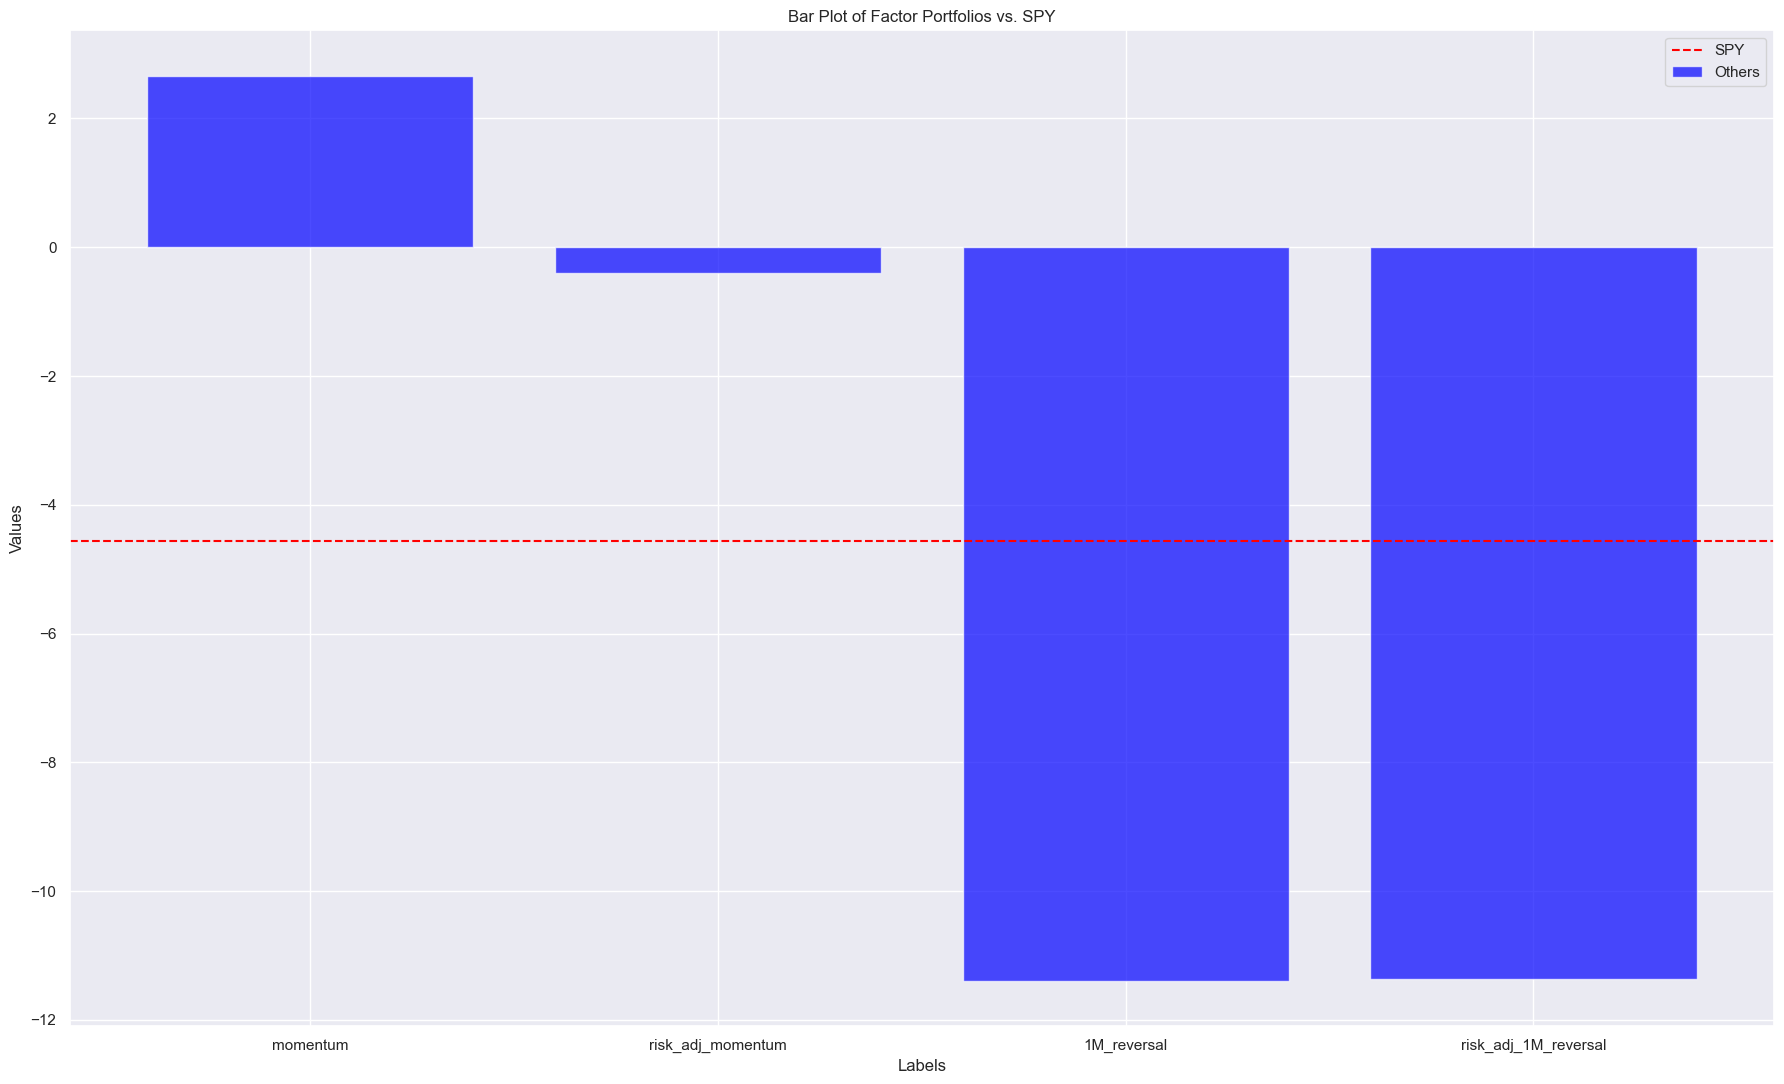

In [170]:
sum_returns = (1+(0.01 * weekly_returns.apply(pd.to_numeric, errors='coerce'))).prod(axis=1) - 1
plot_barplot(sum_returns.values * 100, weekly_returns['Portfolio'].values)

C:\Users\food4thought\AppData\Local\Temp\ipykernel_24188\3430053893.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)


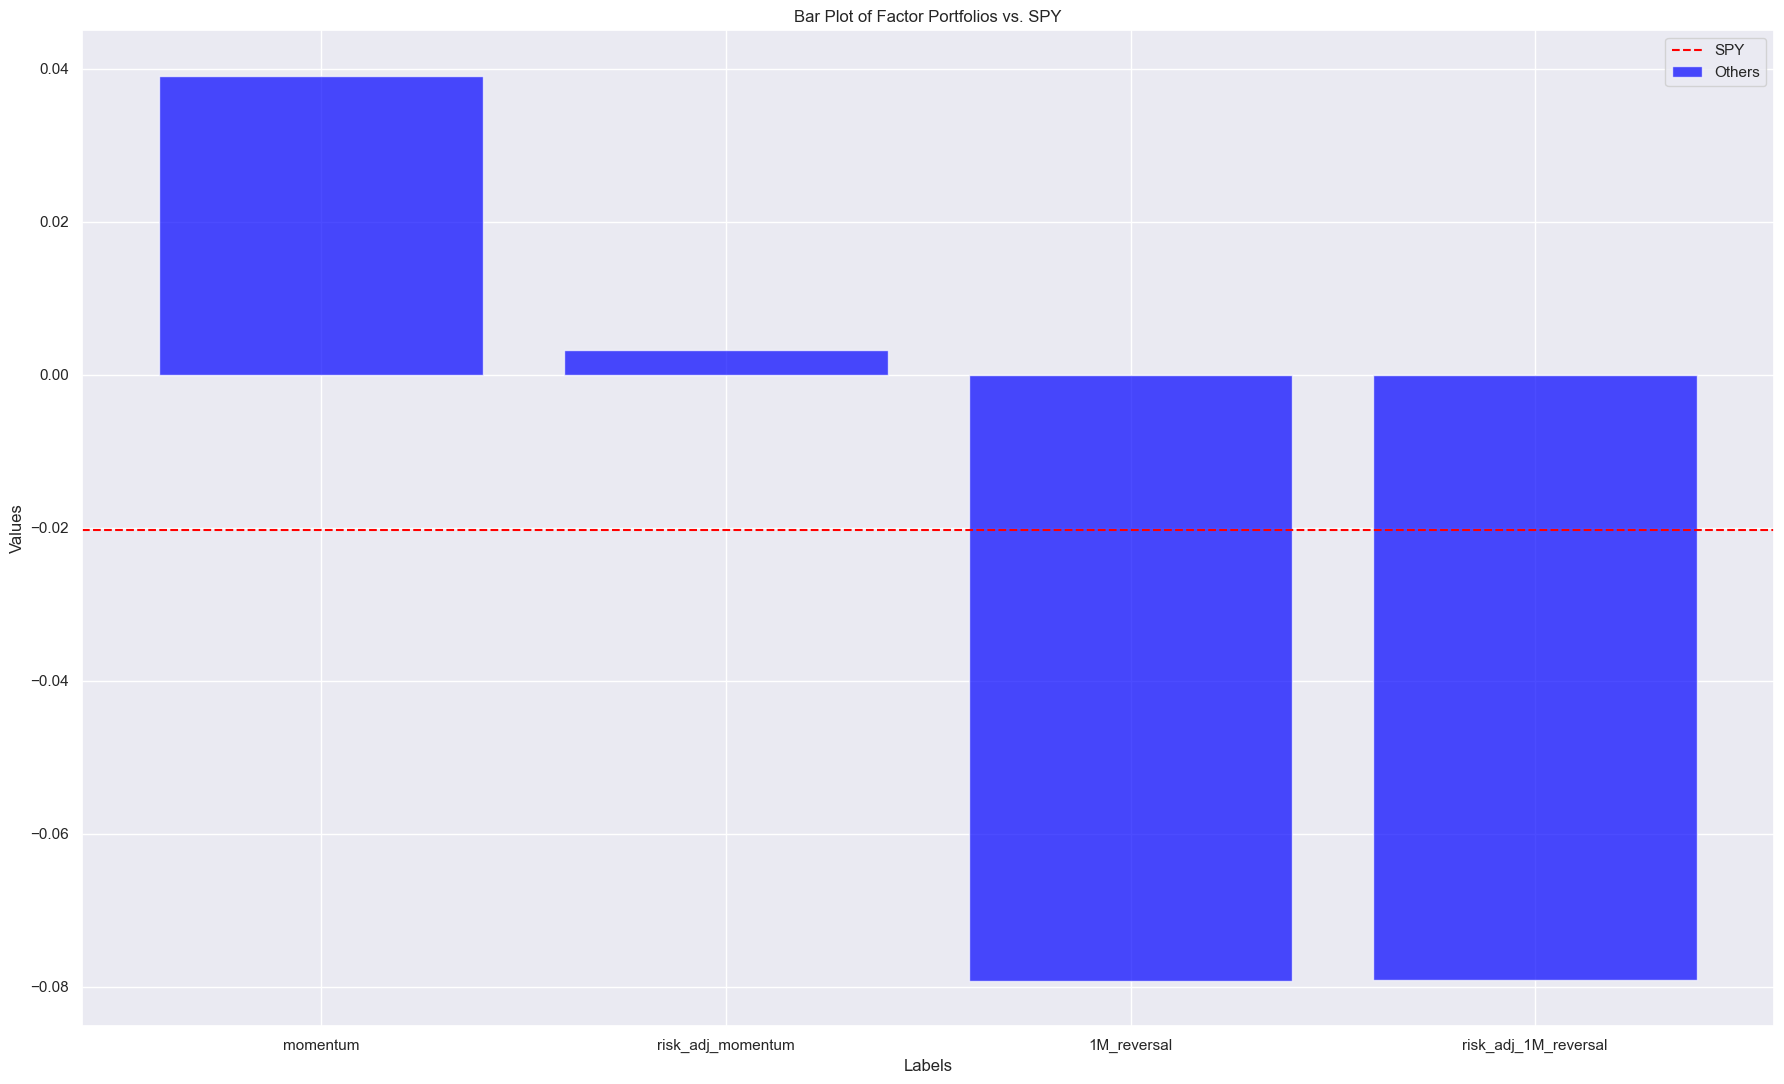

In [171]:
sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)
plot_barplot(sharpe_ratios.values, weekly_returns['Portfolio'].values)